# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import math
from copy import deepcopy
from functools import cmp_to_key
from scipy.spatial import Delaunay
import itertools
from typing import Set, List
from networkx import Graph

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
from typing import List
TOLERANCE = 0.3

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

def compute_determinant_with_numpy(matrix):
    np_array = np.array(matrix) 
    return np.linalg.det(np_array)

def get_determinant_3x3(a, b, c, method):
    return method([[a[0], a[1], 1], [b[0], b[1], 1], [c[0], c[1], 1]])

def numpy_get_determinant_3x3(a, b, c):
    return get_determinant_3x3(a, b, c, compute_determinant_with_numpy)

def orient(a, b, c):
    return numpy_get_determinant_3x3(a, b, c)

def angle3pt(a, b, c):
    """Counterclockwise angle in degrees by turning from a to c around b
        Returns a float between 0.0 and 360.0"""
    ang = math.degrees(
        math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

def triangulatePolygon(polygonPoints):
    preTriangulation = Delaunay(polygonPoints)
    preTriangulation = preTriangulation.simplices.tolist()
    triangulation = []
    for triangle in preTriangulation:
        firstIndex = triangle[0]
        curIndex = (firstIndex + 1) % len(polygonPoints)
        pointId = 1
        while pointId != 3 and curIndex != firstIndex:
            if triangle[pointId] == curIndex:
                pointId += 1
            curIndex = (curIndex + 1) % len(polygonPoints)
        if pointId == 3:
            triangulation.append(triangle)
    return triangulation

INDEPENDENT_SET_LEMMA_DEGREE = 8


def planarIndependentSet(graph, blackList=list(), degreeLim=INDEPENDENT_SET_LEMMA_DEGREE):
    
    unmarkedNodes = {
        node
        for node in graph.nodes()
        if graph.degree(node) <= degreeLim and
           node not in blackList
    }

    independentSet = set()

    while len(unmarkedNodes) > 0:
        node = unmarkedNodes.pop()
        independentSet.add(node)
        unmarkedNodes -= set(graph.neighbors(node))

    return independentSet

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[], texts=[]):
        self.points=points
        self.lines=lines
        self.texts=texts

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
    
class TextsCollection:
    def __init__(self, texts, **kwargs):
        self.texts = texts
        self.kwargs = kwargs
        
    def add(self, text):
        self.texts.append(text)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, algProcessor = None, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.algProcessor = algProcessor
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.16)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_triangulate = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_rect)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_triangulate = Button(ax_triangulate, 'Trianguluj')
        b_triangulate.on_clicked(self.callback.perform_triangulation)
        return [b_prev, b_next, b_add_point, b_add_line, b_triangulate]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure(figsize=(9.5,9.5), dpi= 100, facecolor='w', edgecolor='k')
        self.callback = _Button_callback(self.scenes, self.algProcessor)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

In [3]:
# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes, algProcessor):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []
        self.added_texts = []
        self.algProcessor = algProcessor

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def perform_triangulation(self, event):
        self.algProcessor.endPolygonalAreaDefining()
        self.i = self.algProcessor.getValidSceneId()
        self.draw(autoscaling = False)
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
   
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        if self.algProcessor:
            self.algProcessor.processMouseEvent(event)
            self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if self.algProcessor.polygonalArea:
            self.scenes = self.algProcessor.getScenes()
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].texts + self.added_texts):
            for text in collection.texts:
                self.ax.text(text[0][0], text[0][1], text[1], **collection.kwargs)
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [4]:
class PlotDecorator():
    
    def __init__(self, decorationSettings = {}):
        self.polPointSize = decorationSettings['poligonPointSize'] if \
             ('poligonPointSize' in decorationSettings) else 40
        self.polPointColor = decorationSettings['poligonPointColor'] if \
             ('poligonPointColor' in decorationSettings) else '#000000'
        self.polLineSize = decorationSettings['poligonLineSize'] if \
            ('poligonLineSize' in decorationSettings) else 3
        self.polLineColor = decorationSettings['poligonLineColor'] if \
            ('poligonLineColor' in decorationSettings) else '#00007f'
        self.divLinePointSize = decorationSettings['divLinePointSize'] if \
            ('divLinePointSize' in decorationSettings) else 40
        self.divLinePointColor = decorationSettings['divLinePointColor'] if \
            ('divLinePointColor' in decorationSettings) else '#7F7F7F'
        self.divLineLineSize = decorationSettings['divLineLineSize'] if \
            ('divLineLineSize' in decorationSettings) else 3
        self.divLineLineColor = decorationSettings['divLineLineColor'] if \
            ('divLineLineColor' in decorationSettings) else '#7F7F7F'
        self.polygonCaptionTextColor = decorationSettings['polygonCaptionTextColor'] if \
            ('polygonCaptionTextColor' in decorationSettings) else '#00007F'
        self.triangleLineSize = decorationSettings['triangleLineSize'] if \
            ('triangleLineSize' in decorationSettings) else 1
        self.triangleLineColor = decorationSettings['triangleLineColor'] if \
            ('triangleLineColor' in decorationSettings) else '#007f00'
        self.triangleCaptionTextColor = decorationSettings['triangleCaptionTextColor'] if \
            ('triangleCaptionTextColor' in decorationSettings) else '#007F00'
        self.indeSetPointSize = decorationSettings['indeSetPointSize'] if \
             ('indeSetPointSize' in decorationSettings) else 40
        self.indeSetPointColor = decorationSettings['indeSetPointColor'] if \
             ('indeSetPointColor' in decorationSettings) else '#ff0000'
            
    def plotDataToPlotCollections(self, plotData):
        points = []
        if 'polygonsPoints' in plotData:
            points.append(PointsCollection(deepcopy(plotData['polygonsPoints']),
                                           s=self.polPointSize, color=self.polPointColor))
        if 'divLinePoints' in plotData:
            points.append(PointsCollection(deepcopy(plotData['divLinePoints']),
                                           s=self.divLinePointSize, color=self.divLinePointColor))
        if 'indeSetPoints' in plotData:
            points.append(PointsCollection(deepcopy(plotData['indeSetPoints']),
                                           s=self.indeSetPointSize, color=self.indeSetPointColor))
        
        lines = []
        if 'polygonsLines' in plotData:
            lines.append(LinesCollection(deepcopy(plotData['polygonsLines']),
                                           linewidth=self.polLineSize, color=self.polLineColor))
        if 'divLineLines' in plotData:
            lines.append(LinesCollection(deepcopy(plotData['divLineLines']),
                                           linewidth=self.divLineLineSize, color=self.divLineLineColor))
        if 'trianglesLines' in plotData:
            lines.append(LinesCollection(deepcopy(plotData['trianglesLines']),
                                           linewidth=self.triangleLineSize, color=self.triangleLineColor))
        texts = []
        if 'polygonsCaptions' in plotData:
            texts.append(TextsCollection(deepcopy(plotData['polygonsCaptions']), color=self.polygonCaptionTextColor))
        if 'trianglesCaptions' in plotData:
            texts.append(TextsCollection(deepcopy(plotData['trianglesCaptions']), color=self.triangleCaptionTextColor))
        return (points, lines, texts)

In [48]:
AREA_X_RANGE = [-100, 100]
AREA_Y_RANGE = [-100, 100]
PARTS_PER_SIDE_OF_AREA = 10

class PolygonalArea:
    
    def __init__(self):
        self.points = []
        self.polygons = []
        self.onSplitting = False
        self.clickTolerance = 0.0
        self.curDivLine = []
        self.areaXRange = []
        self.areaYRange = []
        self.partsPerSideOfArea = 0
        self.initArea(AREA_X_RANGE, AREA_Y_RANGE, PARTS_PER_SIDE_OF_AREA)
        
    def clear(self):
        self.points = []
        self.polygons = []
        self.onSplitting = False
        self.clickTolerance = 0.0
        self.curDivLine = []
        self.areaXRange = []
        self.areaYRange = []
        self.partsPerSideOfArea = 0
        
    def initArea(self, areaXRange, areaYRange, partsPerSideOfArea):
        self.clear()
        self.areaXRange = deepcopy(areaXRange)
        self.areaYRange = deepcopy(areaYRange)
        self.partsPerSideOfArea = partsPerSideOfArea
        pointsIndicies = []
        partXLength = (areaXRange[1] - areaXRange[0]) / partsPerSideOfArea
        partYLength = (areaYRange[1] - areaYRange[0]) / partsPerSideOfArea
        for i in range(partsPerSideOfArea):
            pointsIndicies.append(self.addPoint([areaXRange[0] + i * partXLength, areaYRange[0]]))
        for i in range(partsPerSideOfArea):
            pointsIndicies.append(self.addPoint([areaXRange[1] - i * partXLength, areaYRange[0] + i * partYLength]))
        for i in range(partsPerSideOfArea):
            pointsIndicies.append(self.addPoint([areaXRange[0], areaYRange[1] - i * partYLength]))
        self.createPolygonFromPoints(pointsIndicies)
        self.clickTolerance = max(areaXRange[1] - areaXRange[0], areaYRange[1] - areaYRange[0]) / 70
        
    def addPoint(self, pointsCords):
        if pointsCords not in self.points:
            self.points.append(deepcopy(pointsCords))
        return self.points.index(pointsCords)
    
    def getPointAtIndex(self, pointIndex):
        return deepcopy(self.points[pointIndex])
    
    def getIndexOfPoint(self, pointCords):
        return self.points.index(pointCords)
    
    def createPolygonFromPoints(self, pointsIndicies):
        self.polygons.append(deepcopy(pointsIndicies))
        
    def getAllPolygons(self):
        return [[self.getPointAtIndex(index) for index in polygon] for polygon in self.polygons]
    
    def getPolygonAtIndex(self, polygonIndex):
        return [self.getPointAtIndex(index) for index in self.polygons[polygonIndex]]
    
    def getPolygonCaption(self, polygonIndex):
        polygonPoints = self.getPolygonAtIndex(polygonIndex)
        xSum = 0
        ySum = 0
        for i in range(len(polygonPoints)):
            xSum += polygonPoints[i][0]
            ySum += polygonPoints[i][1]
        xSum /= len(polygonPoints)
        ySum /= len(polygonPoints)
        return [[[xSum, ySum], str(polygonIndex)]]
        
    def toPlotData(self):
        plotData = {}
        polygonsPoints = self.getAllPolygons()
        plotData['polygonsPoints'] = [point for polygon in polygonsPoints for point in polygon]
        plotData['polygonsLines'] = [[polygon[index], polygon[(index + 1) % len(polygon)]]
                                     for polygon in polygonsPoints
                                     for index in range(len(polygon))]
        plotData['divLinePoints'] = [self.getPointAtIndex(pointId) for pointId in self.curDivLine]
        plotData['divLineLines'] = [[self.getPointAtIndex(self.curDivLine[pointId]),
                                     self.getPointAtIndex(self.curDivLine[pointId + 1])] 
                                    for pointId in range(len(self.curDivLine) - 1)]
        plotData['polygonsCaptions'] = []
        for polId in range(len(self.polygons)):
            plotData['polygonsCaptions'] += self.getPolygonCaption(polId)
        return plotData
    
    def getPolygonsWithPoint(self, pointIndex):
        pointsOfPolygons = []
        for polId in range(len(self.polygons)):
            polygon = self.polygons[polId]
            for pointId in range(len(polygon)):
                if polygon[pointId] == pointIndex:
                    pointsOfPolygons.append([polId, pointId])
        return pointsOfPolygons
    
    def getPolygonToSplit(self, polygonsForBegin):
        for polIdPointId in polygonsForBegin:
            polygon = self.polygons[polIdPointId[0]]
            polAngle = angle3pt(self.getPointAtIndex(polygon[(polIdPointId[1] + 1) % len(polygon)]),
                               self.getPointAtIndex(polygon[(polIdPointId[1] + 0) % len(polygon)]),
                               self.getPointAtIndex(polygon[(polIdPointId[1] - 1) % len(polygon)]))
            divLineAngle = angle3pt(self.getPointAtIndex(polygon[(polIdPointId[1] + 1) % len(polygon)]),
                               self.getPointAtIndex(polygon[(polIdPointId[1] + 0) % len(polygon)]),
                               self.getPointAtIndex(self.curDivLine[1]))
            if 0.0 < divLineAngle < polAngle:
                return polIdPointId
        return None
    
    def splitPolygonIntoTwo(self, polygonToSplitFromPoint):
        polygon = self.polygons[polygonToSplitFromPoint[0]]
        firstPolygon = deepcopy(self.curDivLine)
        beginPointIdInPol = polygon.index(firstPolygon[0])
        endPointIdInPol = polygon.index(firstPolygon[-1])
        i = endPointIdInPol
        while i != beginPointIdInPol:
            firstPolygon.append(polygon[i])
            i = (i + 1) % len(polygon)
        secondPolygon = deepcopy(list(reversed(self.curDivLine)))
        i = beginPointIdInPol
        while i != endPointIdInPol:
            secondPolygon.append(polygon[i])
            i = (i + 1) % len(polygon)
        self.polygons[polygonToSplitFromPoint[0]] = firstPolygon
        self.polygons.append(secondPolygon)
    
    def processDivLine(self):
        polygonsForBegin = self.getPolygonsWithPoint(self.curDivLine[0])
        toSplit = self.getPolygonToSplit(polygonsForBegin)
        if toSplit == None or self.curDivLine[-1] not in self.polygons[toSplit[0]]:
            self.curDivLine = []
            return
        self.splitPolygonIntoTwo(toSplit)
        self.curDivLine = []
    
    def processClickedPoint(self, clickedPoint):
        selPolId, selPointId = -1, -1
        for polId in range(len(self.polygons)):
            polygon = self.polygons[polId]
            for pointId in range(len(polygon)):
                point = self.getPointAtIndex(polygon[pointId])
                if dist(point, clickedPoint) < self.clickTolerance:
                    selPolId = polId
                    selPointId = pointId
                    break
        if self.onSplitting:
            if selPolId == -1:
                self.curDivLine.append(self.addPoint(clickedPoint))
            else:
                self.curDivLine.append(self.polygons[selPolId][selPointId])
                self.processDivLine()
                self.onSplitting = False
        else:
            if selPointId != -1:
                self.onSplitting = True
                self.curDivLine.append(self.polygons[selPolId][selPointId])
    
    def processMouseEvent(self, event):
        clickedPoint = (event.xdata, event.ydata)
        self.processClickedPoint(clickedPoint)
    
    def getPointsDb(self):
        return self.points
    
    def getPolygonsDb(self):
        return self.polygons

In [49]:
class PolygonsTriangulator:
    
    def __init__(self, polygonalArea):
        self.polygonalArea = polygonalArea
        self.points = self.polygonalArea.getPointsDb()
        self.polygons = self.polygonalArea.getPolygonsDb()
        self.triangulations = []
        
    def performPolygonTriangulation(self, polygonId):
        polygonPoints = self.polygonalArea.getPolygonAtIndex(polygonId)
        polygonPointsIndicies = self.polygons[polygonId]
        triangulation = triangulatePolygon(polygonPoints)
        finalTriangulation = [[polygonPointsIndicies[pointId]
                          for pointId in triangle]
                         for triangle in triangulation]
        return [polygonId, finalTriangulation]
        
    def performTriangulation(self):
        self.triangulations = [self.performPolygonTriangulation(polId) for polId in range(len(self.polygons))]
        
    def getTriangulation(self):
        return deepcopy(self.triangulations)
        
    def getAllTriangles(self):
        return [[self.polygonalArea.getPointAtIndex(pointId) for pointId in triangle]
                for polTriangulation in self.triangulations
                for triangle in polTriangulation[1]]
    
    def getTriangleAtIndex(self, polygonIndex, triangleIndex):
        return [self.polygonalArea.getPointAtIndex(pointId) for pointId in self.triangulations[polygonIndex][1][triangleIndex]]
    
    def getTriangleCaption(self, polygonIndex, triangleIndex):
        polygonPoints = self.getTriangleAtIndex(polygonIndex, triangleIndex)
        xSum = 0
        ySum = 0
        for i in range(len(polygonPoints)):
            xSum += polygonPoints[i][0]
            ySum += polygonPoints[i][1]
        xSum /= len(polygonPoints)
        ySum /= len(polygonPoints)
        return [[[xSum, ySum], str(polygonIndex) + '.' + str(triangleIndex)]]
        
    def toPlotData(self):
        plotData = {}
        trianglesPoints = self.getAllTriangles()
        plotData['trianglesLines'] = [[triangle[index], triangle[(index + 1) % len(triangle)]]
                                     for triangle in trianglesPoints
                                     for index in range(len(triangle))]
        plotData['trianglesCaptions'] = []
        for polId in range(len(self.triangulations)):
            for triangId in range(len(self.triangulations[polId][1])):
                plotData['trianglesCaptions'] += self.getTriangleCaption(polId, triangId)
        return plotData
        

In [50]:
class Triangle:
    
    def __init__(self, triangleId, polygonalArea, pointsIndicies, polygonId=-1):
        self.triangleId = triangleId
        self.polygonalArea = polygonalArea
        self.pointsIndicies = pointsIndicies
        if polygonId != -1:
            self.polygonId = polygonId
    
    def points(self):
        return [self.polygonalArea.getPointAtIndex(pointIndex) for pointIndex in self.pointsIndicies]
    
    def getPolygonId(self):
        return self.polygonId
    
    def getTriangleId(self):
        return self.triangleId
    
    def getPointsIndicies(self):
        return self.pointsIndicies

In [51]:
class AbstractNode:
    def __init__(self, area: Triangle, children: List):
        self.__area = area
        self.__children = children

    def getChildren(self) -> List:
        return self.__children

    def getArea(self) -> Triangle:
        return self.__area

class AbstractTriangleTree:
    def __init__(self, nodes: List[AbstractNode], rootNode: AbstractNode): # TODO Mateusz do tworzenia nodes chyba najłatwiej wykorzystrać stos
        self.__nodes = nodes
        self.__root = rootNode

    def getRootNode(self) -> AbstractNode:
        return self.__root

    def getNodes(self) -> List[AbstractNode]:
        return self.__nodes

In [52]:
class TrianglesSearchDagNode(AbstractNode):
    
    def __init__(self, triangle, children=[]):
        super().__init__(triangle, children)
    

class TrianglesSearchDag(AbstractTriangleTree):
    
    def __init__(self, nodes, rootNode):
        super().__init__(nodes, rootNode)
        

In [53]:
class TrianglesSearchDagGenerator:
    
    def __init__(self, polygonalArea, polygonsTriangulator):
        self.polygonalArea = polygonalArea
        self.polygonsTriangulator = polygonsTriangulator
        self.points = []
        self.graphPoints = []
        self.polygons = []
        self.triangulations = []
        self.constNodes = []
        self.trianglesSearchDag = None
        self.trianglesSearchDagNodes = []
        self.currentLayer = []
        self.graph = None
        self.nextTriangleId = 0
        self.layers = []
        self.scenesData = []
        
    def init(self):
        self.points = self.polygonalArea.getPointsDb()
        self.graphPoints = range(len(self.points))
        self.polygons = self.polygonalArea.getPolygonsDb()
        self.triangulations = self.polygonsTriangulator.getTriangulation()
        self.constNodes = [0, self.polygonalArea.partsPerSideOfArea, 2 * self.polygonalArea.partsPerSideOfArea]
        self.initGraph()
        
    def initGraph(self):
        self.graph = Graph()
        for polId in range(len(self.polygons)):
            for triangle in self.triangulations[polId][1]:
                self.trianglesSearchDagNodes.append(TrianglesSearchDagNode(
                    Triangle(self.nextTriangleId, self.polygonalArea, triangle, polId)))
                self.currentLayer.append(self.nextTriangleId)
                self.nextTriangleId += 1
                for pointId in range(3):
                    self.graph.add_edge(triangle[pointId], triangle[(pointId + 1) % 3])
        self.saveLayer()
                    
    def getAllTrianglesForLayer(self, layerId):
        return [self.trianglesSearchDagNodes[nodeId].getArea().points() for nodeId in self.layers[layerId]]
    
    def getTriangleCaption(self, nodeId):
        triangle = self.trianglesSearchDagNodes[nodeId].getArea()
        polygonPoints = triangle.points()
        xSum = 0
        ySum = 0
        for i in range(len(polygonPoints)):
            xSum += polygonPoints[i][0]
            ySum += polygonPoints[i][1]
        xSum /= len(polygonPoints)
        ySum /= len(polygonPoints)
        return [[[xSum, ySum], str(triangle.getTriangleId())]]
        
    def layerToPlotData(self, layerId):
        plotData = {}
        trianglesPoints = self.getAllTrianglesForLayer(layerId)
        plotData['trianglesLines'] = [[triangle[index], triangle[(index + 1) % len(triangle)]]
                                     for triangle in trianglesPoints
                                     for index in range(len(triangle))]
        plotData['trianglesCaptions'] = []
        for nodeId in self.layers[layerId]:
            plotData['trianglesCaptions'] += self.getTriangleCaption(nodeId)
        return plotData
    
    def selectedPointsToPlotData(self, indeSetPoints, neighbors):
        plotData = {**self.layerToPlotData(-1)}
        plotData['polygonsPoints'] = [self.polygonalArea.getPointAtIndex(pointId) for pointId in self.graphPoints]
        plotData['indeSetPoints'] = [self.polygonalArea.getPointAtIndex(pointId) for pointId in indeSetPoints]
        plotData['divLinePoints'] = [self.polygonalArea.getPointAtIndex(pointId) for pointId in neighbors]
        return plotData
        
    def addSceneWithIndependentSet(self, indeSetPoints, neighbors=[]):
        self.scenesData.append(self.selectedPointsToPlotData(indeSetPoints, neighbors))
                    
    def saveLayer(self):
        self.layers.append(deepcopy(self.currentLayer))
        self.addSceneWithIndependentSet([])
    
    def getScenesData(self):
        return self.scenesData
    
    def performNextLayer(self):
        independentSet = planarIndependentSet(self.graph, blackList=self.constNodes)
        allNeighbors = []
        for iPoint in independentSet:
            neighbors = list(self.graph.neighbors(iPoint))
            allNeighbors += neighbors
            childrenNodes = []
            for nodeId in self.currentLayer:
                triangle = self.trianglesSearchDagNodes[nodeId].getArea()
                if iPoint in triangle.getPointsIndicies():
                    childrenNodes.append(triangle)
            for neighbour in neighbors:
                self.graph.remove_edge(iPoint, neighbour)
            pointsAppearance = {}
            for node in childrenNodes:
                for point in node.getPointsIndicies():
                    if point not in pointsAppearance:
                        pointsAppearance[point] = 0
                    pointsAppearance[point] += 1
            alonePoints = []
            for key, value in pointsAppearance.items():
                if value == 1:
                    alonePoints.append(key)
            finalNeighbors = []
            lastTriangle = None
            if len(alonePoints) > 0:
                for alonePoint in alonePoints:
                    for node in childrenNodes:
                        if alonePoint in node.getPointsIndicies():
                            if (node.getPointsIndicies().index(iPoint) + 1) % 3 == \
                            node.getPointsIndicies().index(alonePoint):
                                finalNeighbors.append(alonePoint)
                                finalNeighbors.append(node.getPointsIndicies()[
                                    (node.getPointsIndicies().index(finalNeighbors[-1]) + 1) % 3])
                                lastTriangle = node
                                break
                    if lastTriangle:
                        break
            else:
                finalNeighbors = [neighbors[0]]
                lastTriangle = None
                for node in childrenNodes:
                    if finalNeighbors[-1] in node.getPointsIndicies():
                        if (node.getPointsIndicies().index(iPoint) + 1) % 3 == \
                        node.getPointsIndicies().index(finalNeighbors[-1]):
                            finalNeighbors.append(node.getPointsIndicies()[
                                (node.getPointsIndicies().index(finalNeighbors[-1]) + 1) % 3])
                            lastTriangle = node
                            break
            i = 0
            while len(finalNeighbors) != len(neighbors) and i < 100:
                for node in childrenNodes:
                    i += 1
                    if finalNeighbors[-1] in node.getPointsIndicies() and node != lastTriangle:
                        finalNeighbors.append(node.getPointsIndicies()[
                            (node.getPointsIndicies().index(finalNeighbors[-1]) + 1) % 3])
                        lastTriangle = node
                        break
            polygonPoints = [self.polygonalArea.getPointAtIndex(pointId) for pointId in finalNeighbors]
            with open('debugLogs.txt', 'a') as file:
                file.write(js.dumps({"finalNeighbors": finalNeighbors}))
            if len(polygonPoints) == 0:
                continue
            try:
                triangulation = triangulatePolygon(polygonPoints)
                finalTriangulation = [[finalNeighbors[pointId]
                                  for pointId in triangle]
                                 for triangle in triangulation]
                children = [self.trianglesSearchDagNodes[child.getTriangleId()] for child in childrenNodes]
                for triangle in finalTriangulation:
                    self.trianglesSearchDagNodes.append(TrianglesSearchDagNode(
                        Triangle(self.nextTriangleId, self.polygonalArea, triangle), children))
                    self.currentLayer.append(self.nextTriangleId)
                    self.nextTriangleId += 1
                    for pointId in range(3):
                        self.graph.add_edge(triangle[pointId], triangle[(pointId + 1) % 3])
            except:
                pass
            self.currentLayer = [elem for elem in self.currentLayer
                                 if elem not in map(lambda node: node.getTriangleId(), childrenNodes)]
            self.graph.remove_node(iPoint)
        self.addSceneWithIndependentSet(independentSet, allNeighbors)
        self.graphPoints = [elem for elem in self.graphPoints if elem not in independentSet]
        self.saveLayer()
    
    def buildTrianglesSearchDag(self):
        while len(self.currentLayer) > 1:
            self.performNextLayer()
        self.trianglesSearchDag = TrianglesSearchDag(self.trianglesSearchDagNodes, self.trianglesSearchDagNodes[-1])
        
    def getrianglesSearchDag(self):
        return self.trianglesSearchDag

In [54]:
class KirkpatrickAlgorithmProcessor():
    
    def __init__(self):
        self.reset()
            
    def reset(self):
        self.polygonalArea = PolygonalArea()
        self.polygonsTriangulator = PolygonsTriangulator(self.polygonalArea)
        self.trianglesSearchDagGenerator = TrianglesSearchDagGenerator(self.polygonalArea, self.polygonsTriangulator)
        self.onPolygonAreaDefining = True
        self.plotDecorator = PlotDecorator()
        self.trianglesSearchDagGeneratorScenes = []
        self.solutionComputerScenes = []
        self.validSceneId = 0
        self.initialScene = Scene()
        self.updateInitialScene()
        
    def processMouseEvent(self, event):
        if self.onPolygonAreaDefining:
            self.polygonalArea.processMouseEvent(event)
        self.updateInitialScene()
    
    def endPolygonalAreaDefining(self):
        if self.onPolygonAreaDefining:
            self.onPolygonAreaDefining = False
            self.polygonsTriangulator.performTriangulation()
            self.trianglesSearchDagGenerator.init()
            self.trianglesSearchDagGenerator.buildTrianglesSearchDag()
            self.updateInitialScene()
            self.updateTrianglesSearchDagGeneratorScenes()
            self.validSceneId = 0
    
    def toPlotCollections(self):
        plotData = {**self.polygonalArea.toPlotData(),
                    **self.polygonsTriangulator.toPlotData()}
        return self.plotDecorator.plotDataToPlotCollections(plotData)
    
    def updateInitialScene(self):
        points, lines, texts = self.toPlotCollections()
        self.initialScene = Scene(points=points, lines=lines, texts=texts)
        
    def updateTrianglesSearchDagGeneratorScenes(self):
        self.trianglesSearchDagGeneratorScenes = []
        scenesData = self.trianglesSearchDagGenerator.getScenesData()
        for sceneData in scenesData:
            points, lines, texts = self.plotDecorator.plotDataToPlotCollections(sceneData)
            self.trianglesSearchDagGeneratorScenes.append(Scene(points=points, lines=lines, texts=texts))
    
    def getScenes(self):
        return [self.initialScene] + self.trianglesSearchDagGeneratorScenes + self.solutionComputerScenes
    
    def getValidSceneId(self):
        return self.validSceneId

<IPython.core.display.Javascript object>


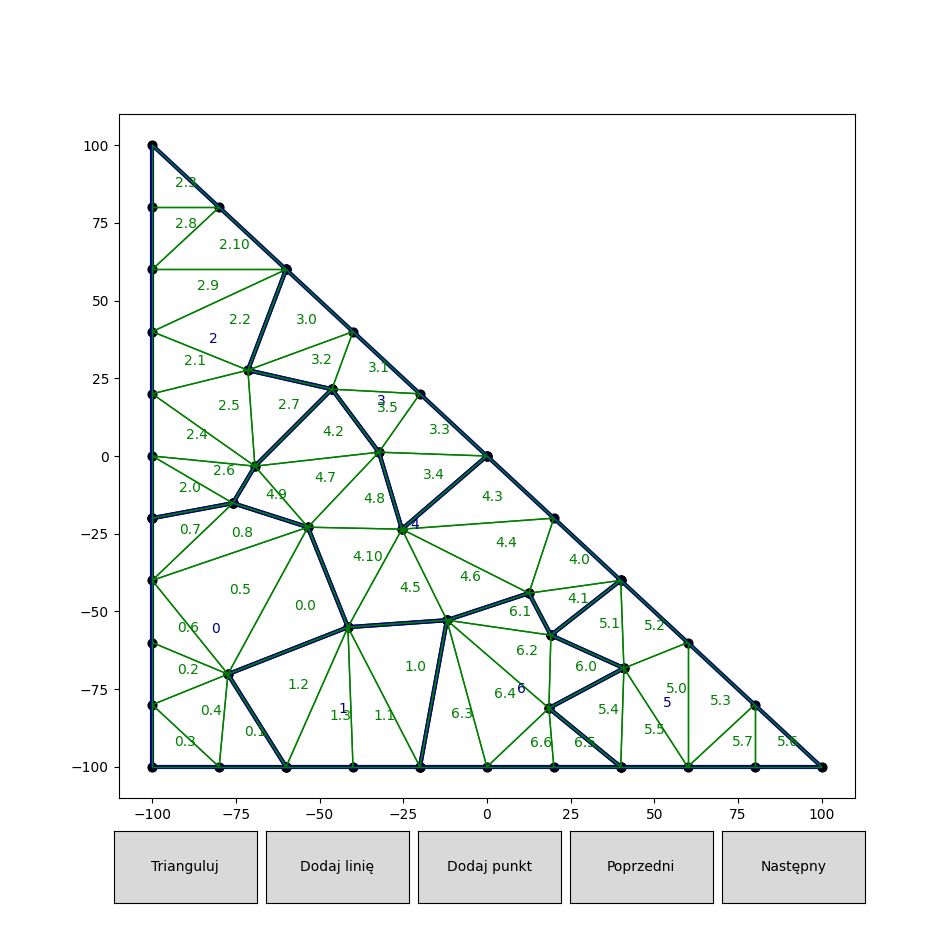

In [55]:
%matplotlib notebook

algProcessor = KirkpatrickAlgorithmProcessor()

plot = Plot(algProcessor = algProcessor)
plot.draw()

## Przeszukiwanie drzewa - dopasowanie trójkątów

In [ ]:
searchScenes = []
createVisualisation = True

def prepareTriangleForScene(triangle: Triangle, color: str):
    points = triangle.points()
    if len(points) != 3:
        raise Exception("Wrong point number in triangle: expected 3 got %d" % len(points))
    return LinesCollection([
        (points[0], points[1]),
        (points[1], points[2]),
        (points[2], points[0])
    ], color=color)

def createNodeScene(point,
                    analisedChildren: List[AbstractNode],
                    currentChild: AbstractNode,
                    futureChildren: List[AbstractNode]):
    sceneTriangles = []
    for child in analisedChildren:
        sceneTriangles.append(prepareTriangleForScene(child.getArea(), "red"))
    for child in futureChildren:
        sceneTriangles.append(prepareTriangleForScene(child.getArea(), "orange"))
    sceneTriangles.append(prepareTriangleForScene(currentChild.getArea(), "green"))
    return Scene([PointsCollection([point], color="blue")],sceneTriangles)

def pointInTriangle(triangle: Triangle, point):
    trianglePoints = triangle.points().sort(key=lambda p: (p[1],p[0]))
    if len(trianglePoints) != 3:
        raise Exception("Wrong point number in triangle: expected 3 got %d" % len(trianglePoints))

    def direction(p1, p2, p3):
        d = (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
        if d < -10e-10: return -1
        elif d > 10e-10: return 1
        else: return 0

    d1 = direction(point, trianglePoints[0], trianglePoints[1])
    d2 = direction(point, trianglePoints[1], trianglePoints[2])
    d3 = direction(point, trianglePoints[2], trianglePoints[0])
    hasNeg = d1 < 0 or d2 < 0 or d3 < 0
    hasPos = d1 > 0 or d2 > 0 or d3 > 0
    return not(hasNeg and hasPos)


def analiseNodes(nodes: List[AbstractNode], point) -> AbstractNode:
    analisedNodes = None
    futureNodes = None
    if createVisualisation:
        analisedNodes = []
        futureNodes = nodes.copy()

    for node in nodes:
        if createVisualisation:
            futureNodes.remove(node)
            searchScenes.append(
                createNodeScene(point, analisedNodes, node, futureNodes)
            )

        triangle = node.getArea()
        if pointInTriangle(triangle, point):
            children = node.getChildren()
            if len(children) > 0:
                return analiseNodes(children, point)
            else:
                return node

        if createVisualisation:
            analisedNodes.append(node)
    raise Exception("Point is in none of the nodes")

def traversTree(tree: AbstractTriangleTree, point):
    analiseNodes([tree.getRootNode()], point)